## Introduction

One way to analyse non equilibrium force timetraces from constraint pulling simulations is via:

$$
\begin{align}
\Delta G(s) &=  \left< W(s) \right>_\text{N} -\frac{\beta}{2}\left<\delta W(s)^2\right>_\text{N} \\
			&=  \left<W(s)\right>_\text{N} - W_{diss}(s)
\end{align}
$$

with $\delta W(s) = W(s) -\left< W(s) \right>_\text{N}$. 
The expression is true if the work distribution is Gaussian. This allows to formulate the friction estimate: 

$$\Gamma = \frac{1}{v_c}\frac{d~W_{diss}(s)}{ds}$$

This appraoch is implemented in the WorkEstimator class and computaionally more efficient than calculating the force autocorrelation function (which is implemented in the ForceEstimator class), because the class works with the work data via the integration of the force timetraces. This allows to reduce the resolution significantly while getting the same reults.

Therefore, we advide to use this approach for large datasets. 

In [1]:
import numpy as np
import dcTMD
from dcTMD.storing import WorkSet
from dcTMD.dcTMD import WorkEstimator

In [2]:
# define variables
velocity = 0.001
res = 1
verbose = True
temperature = 290


### I. create work set

To calculate free energy and friction estimates a workset is needed. It contains the integrated force time traces. 
First, an array containing the filenames is generated. This can be done via the function dcTMD.io.load_pullf() which takes either a glob pattern or a file containing the pullf file names as argument.

In [3]:
pullf_files = '../../tests/testdata/pullf_filenames.dat'
pullf_files = '../../tests/testdata/*pullf.xvg'
filenames = dcTMD.io.load_pullf(pullf_files)

filenames


file ../../tests/testdata/*pullf.xvg not found. using glob.glob(../../tests/testdata/*pullf.xvg)


['../../tests/testdata/t_middle_32_pullf.xvg',
 '../../tests/testdata/t_middle_03_pullf.xvg',
 '../../tests/testdata/t_middle_34_pullf.xvg',
 '../../tests/testdata/t_middle_24_pullf.xvg',
 '../../tests/testdata/t_middle_21_pullf.xvg',
 '../../tests/testdata/t_middle_04_pullf.xvg',
 '../../tests/testdata/t_middle_29_pullf.xvg',
 '../../tests/testdata/t_middle_16_pullf.xvg',
 '../../tests/testdata/t_middle_30_pullf.xvg',
 '../../tests/testdata/t_middle_19_pullf.xvg',
 '../../tests/testdata/t_middle_01_pullf.xvg',
 '../../tests/testdata/t_middle_28_pullf.xvg',
 '../../tests/testdata/t_middle_26_pullf.xvg',
 '../../tests/testdata/t_middle_31_pullf.xvg',
 '../../tests/testdata/t_middle_09_pullf.xvg',
 '../../tests/testdata/t_middle_17_pullf.xvg',
 '../../tests/testdata/t_middle_25_pullf.xvg',
 '../../tests/testdata/t_middle_05_pullf.xvg']

Second, the workset is created by creating a WorkSet instance which is fitted with the filenames. 

The resolution parameter controls the striding of the data set. The reduction is performed after integration the force time traces. For long trajectories e.g. 35,000,000 frames it is advisory to use a resolution > 1000 to not exceed your hardware.    

In [4]:
# create WorkSet instance
workset = WorkSet(velocity=velocity,
                  resolution=res,
                  verbose=False,
                  )
workset


WorkSet(velocity=0.001)

In [5]:
# fit/fill workset
workset.fit(filenames)
# save workset
#dcTMD.storing.save('my_workset', workset)



Loading & integrating force files: 100%|██████████| 18/18 [00:00<00:00, 41.62it/s]


WorkSet(velocity=0.001)

In [6]:
print(vars(workset))

{'velocity': 0.001, 'resolution': 1, 'verbose': False, 'X': ['../../tests/testdata/t_middle_32_pullf.xvg', '../../tests/testdata/t_middle_03_pullf.xvg', '../../tests/testdata/t_middle_34_pullf.xvg', '../../tests/testdata/t_middle_24_pullf.xvg', '../../tests/testdata/t_middle_21_pullf.xvg', '../../tests/testdata/t_middle_04_pullf.xvg', '../../tests/testdata/t_middle_29_pullf.xvg', '../../tests/testdata/t_middle_16_pullf.xvg', '../../tests/testdata/t_middle_30_pullf.xvg', '../../tests/testdata/t_middle_19_pullf.xvg', '../../tests/testdata/t_middle_01_pullf.xvg', '../../tests/testdata/t_middle_28_pullf.xvg', '../../tests/testdata/t_middle_26_pullf.xvg', '../../tests/testdata/t_middle_31_pullf.xvg', '../../tests/testdata/t_middle_09_pullf.xvg', '../../tests/testdata/t_middle_17_pullf.xvg', '../../tests/testdata/t_middle_25_pullf.xvg', '../../tests/testdata/t_middle_05_pullf.xvg'], 'time_': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.9998e+03, 1.9999e+03,
       2.0000e+03]), 'work_':

### II. check normality of work distribution

One of the main conditions which need to be fulfilled for dcTMD is a normally distributed work.

This can be checked via different methods. e.g. plotting the work time traces, normality checks at different x positions, Kolmogorov-Smirnov Test, Shapiro-Wilk Test

CAUTION: if the work distribution is not normal you results are compromised. And a path separation is necessary. For the theory on path separation see...

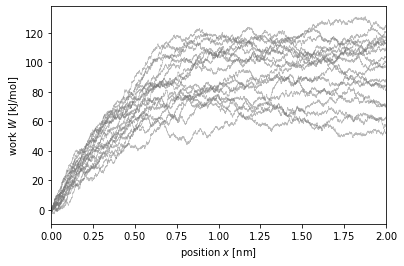

In [7]:
# plot workset
import matplotlib.pyplot as plt
from dcTMD.utils import plotting

fig, ax = plt.subplots()
plotting.plot_worklines(workset.position_, workset.work_, ax)
plt.show()

shapiro wilkins results at x=0.5 is ShapiroResult(statistic=0.9809889793395996, pvalue=0.9596364498138428)
Kolmogorov-Smirnov results at x=0.5 is KstestResult(statistic=1.0, pvalue=0.0)
shapiro wilkins results at x=1.5 is ShapiroResult(statistic=0.9350144863128662, pvalue=0.23768189549446106)
Kolmogorov-Smirnov results at x=1.5 is KstestResult(statistic=1.0, pvalue=0.0)


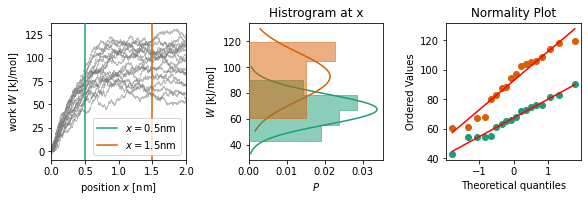

In [8]:
# check if work distribution follows a normal distribution
from scipy.stats import kstest, shapiro
from dcTMD.utils import plotting

index = [5000, 15000]
x = workset.position_

fig, axs = plotting.plot_worknormalitychecks(x, workset.work_, index)

for i, p in enumerate(index):
    # Shapiro-Wilk Test
    shapiro_test = shapiro(workset.work_[:,p])
    print(f'shapiro wilkins results at x={x[p]} is {shapiro_test}')
    # Kolmogorov-Smirnov Test
    kstest_test = kstest(workset.work_[:,p], 'norm')
    print(f'Kolmogorov-Smirnov results at x={x[p]} is {kstest_test}')

### III. derive estimates from workset

1. create WorkEstimator instance
2. fit WorkEstimator instance with previously created workset

In [9]:
# create WorkEstimator instance
workestimator = WorkEstimator(temperature)
# fit existing workset
# or load an existing workset
# workset = dcTMD.storing.load(my_workset)
workestimator.fit(workset)
vars(workestimator)

{'temperature': 290,
 'verbose': False,
 'work_set': WorkSet(velocity=0.001),
 'position_': array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 1.9998e+00, 1.9999e+00,
        2.0000e+00]),
 'names_': array(['t_middle_32_pullf.xvg', 't_middle_03_pullf.xvg',
        't_middle_34_pullf.xvg', 't_middle_24_pullf.xvg',
        't_middle_21_pullf.xvg', 't_middle_04_pullf.xvg',
        't_middle_29_pullf.xvg', 't_middle_16_pullf.xvg',
        't_middle_30_pullf.xvg', 't_middle_19_pullf.xvg',
        't_middle_01_pullf.xvg', 't_middle_28_pullf.xvg',
        't_middle_26_pullf.xvg', 't_middle_31_pullf.xvg',
        't_middle_09_pullf.xvg', 't_middle_17_pullf.xvg',
        't_middle_25_pullf.xvg', 't_middle_05_pullf.xvg'], dtype='<U32'),
 'W_mean_': array([0.00000000e+00, 4.41837458e-02, 4.44572742e-02, ...,
        9.33136501e+01, 9.32887153e+01, 9.32516402e+01]),
 'W_diss_': array([0.00000000e+00, 1.20311533e-03, 5.75789631e-03, ...,
        1.06892075e+02, 1.06779638e+02, 1.06653346e+02]),
 'dG_'

#### Visualize results
In the package a couple of simple plot functions to get an overview of the results are implemented. e.g. plot_dcTMD_results()

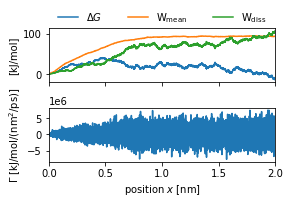

In [10]:
# plot dcTMD results
from dcTMD.utils import plotting

fig, axs = plotting.plot_dcTMD_results(workestimator.position_,
                                      workestimator,
                                      workestimator.friction_)

plt.show()

#### Smooth friction estimate
Finally, the friction estimate needs to be smoothed.
This can be done via 
dcTMD.utils.smoothing.gaussfilter_friction() or 
dcTMD.WorkEstimator.smooth_friction(sigma, mode)
sigma is the standard deviation of gaussian kernel in nm
the mode parameter determines how the input array is extended beyond its boundaries.

*Caution:* this can lead to long computations using large datasets and a big smoothing window.

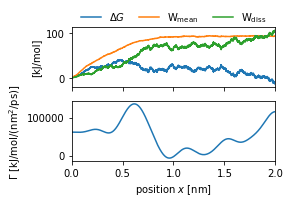

In [11]:
# smooth friction and plot results
workestimator.smooth_friction(sigma=0.1, mode='reflect')


fig, axs = plotting.plot_dcTMD_results(workestimator.position_,
                                      workestimator,
                                      workestimator.friction_smooth_)
plt.show()

### IV. Error estimation

The error estimation of the results is implemented via bootstrapping

Bootstrapping progress: 100%|██████████| 1000/1000 [00:00<00:00, 1165.48it/s]


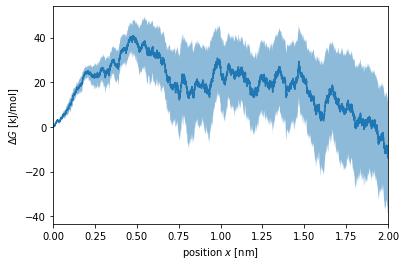

Bootstrapping progress: 100%|██████████| 1000/1000 [00:00<00:00, 1115.62it/s]


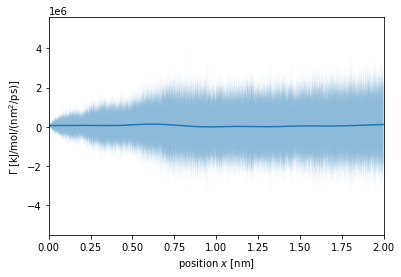

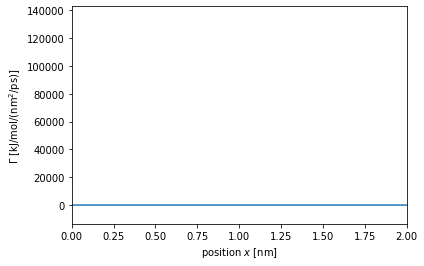

In [21]:

n_resamples = 1000

# bootstrapping error in mode std
mode = 'std'
workestimator.estimate_free_energy_errors(n_resamples, mode)
x = workestimator.position_
dG = workestimator.dG_
s_dG = workestimator.s_dG_

fig, ax = plt.subplots()
plotting.plot_dG(x, dG, ax)
ax.fill_between(x, dG-s_dG, dG+s_dG, alpha=0.5)
plt.show()

Bootstrapping progress: 100%|██████████| 1000/1000 [00:00<00:00, 1169.01it/s]


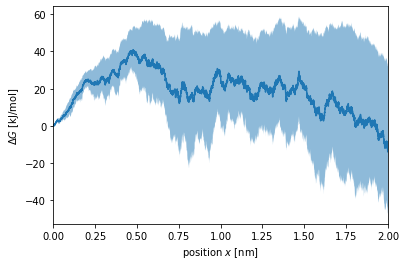

In [13]:
# bootstrapping error in with confidence interval 
# this gives a lower and upperbound estimate
confidence_interval = 0.9
mode = confidence_interval
workestimator.estimate_free_energy_errors(n_resamples, mode)

x = workestimator.position_
dG = workestimator.dG_
s_dG = workestimator.s_dG_

fig, ax = plt.subplots()
plotting.plot_dG(x, dG, ax)
plt.fill_between(x, s_dG[0], s_dG[1], alpha=0.5)
plt.show()


### V. Save results

In [14]:
# save data as .npz and .dat file
outname = 'test'
dcTMD.io.write_output(outname, workestimator)

results = np.load(f'test_N{len(workestimator.names_)}_dG.npz')

results.files

save file test_N18_dG.dat
save file test_N18_dG.npz


['x',
 'Wmean',
 'Wdiss',
 'dG',
 'Gamma',
 's_W_mean',
 's_W_diss',
 's_dG',
 'Gamma_smooth',
 's_Gamma']